# Propensity Score Matching: A Practitioner's Appendium


## TL;DR
This article discusses the usage and a common pitfall of the Propensity Score Matching (PSM) from a working data scientist's perspective in the language that (hopefully) is accessible to most data scientists.

1. In a simulation exercise, I show PSM can be used to remove functional form dependence.
1. The key assumption in matching is the ignorability assumption. You will see why you want to make sure this assumption holds.
1. You will find a user-friendly way to test the ignorability assumption.
1. Code snippets using Python libraries that are familiar to most data scientists are provided.


## Introduction

It is well known to data scientists that “correlation does not imply causation.” For example, let’s consider a hypothetical situation where a hospital is considering promoting either of the following doctors (I’m sure in reality hospitals do not work this way). One candidate typically ends up with patients that either died or still had ongoing conditions when they left the hospital while the other candidate’s patients mostly fully recovered from their illness. Does this comparison mean the former is incompetent? 

On the contrary, it is possible the former is far more competent. For various reasons, good doctors work with tricky cases more often and tricky cases are tricky to work with even for the best doctors. This is called the selection effect.

Selection effect can mute or, in extreme cases like the one above, completely opposite the correlation from causation. Unfortunately, the selection effect is everywhere in human activities. Tech sector is no exception. For instance, hosts that display more photos on Airbnb might have more bookings. But this mere correlation does not imply actionable interventions unless you can establish causation. Encourage hosts of horrible places to upload more photos of their horrible places? Good luck with that.

Then how to establish the causation that a good doctor *is* good? To do so, one way is to figure out factors that influence the “trickiness” of an illness and control them in your analysis. Let’s call it controlling confounders. Another way is to find a subset of patients from the two doctors’ patient pools that are similar in their severity before they are admitted and do the comparison only on this subset. The latter is known as the matching method. 

In the rest of this article, I will first introduce a popular matching method called propensity score matching (PSM), which I think is the most feasible matching method when you work with large datasets in the tech sector. Then I will walk you through the reasons why you want to choose the PSM over controlling confounders. Lastly, I will highlight to you a super duper important assumption of PSM and give you a simple way to test it.


### A Note on the Terminology

We have three important terms in this article that are typically unseen in predictive modeling exercises.

- Treatment: intervention, the item that is different from the status quo you're contemplating to apply. I will use its verb variants like "treat" or "treated" to describe applying the intervention to a certain population. In this article, I will only discuss the situation where the treatment is binary. That is, we have one intervention and one status quo, the typical A/B case.
- Propensity score, or simply propensity: the probability of being treated. The reason I insist on using this "foreign" term is that it will be easier for you to find relevant literature should you decide to read on.
- Outcome: the metric you care about, typically your primary business metric that you're hoping to optimize.

For folks that are more familiar with the A/B experiment, treatment means the new item you're testing against the status quo; propensity means the probability of a subject receiving the new item; and outcome is your experiment's primary metric. Unlike the A/B experiment, we're working with the case where the treatment/intervention is not completely randomly assigned.

In [ ]:
# As of writing, Google's colab has an older version of lightgbm, 
# which is not compatible with the outcome model's code
!pip uninstall -y lightgbm
!pip install lightgbm

Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0MB 7.5MB/s 


### Data Generation

Let's consider a hypothetical situation where you have a binary treatment, a continuous outcome, several features that may or may not be important to the propensity or the outcome. Let's generate some simulation data to match this situation. The reason we're working with the generated data is that we can control the data generating process so that we will have a truth to compare against.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import bernoulli
from scipy.special import expit

np.random.seed(0)
N = 10_000
df = pd.DataFrame(
    np.random.rand(N, 6),
    columns=list('abcdef'),
)
df['true_ps'] = expit(df['a'] + 3 * df['b'] - 0.2 * df['c'] - 2 * df['f'])
df['treatment'] = bernoulli.rvs(df['true_ps'])
df['outcome'] = (
    (
        15 * df['a'] / np.exp(df['c'])) ** df['b'] 
        + (0.7 * np.sin(df['b']) 
        - 0.3 * np.exp(df['c']) ** 2
    ) + np.random.normal(size=N)
)
df.head()

,a,b,c,d,e,f,true_ps,treatment,outcome
0,0.548814,0.715189,0.602763,0.544883,0.423655,0.645894,0.782797,0,1.740649
1,0.437587,0.891773,0.963663,0.383442,0.791725,0.528895,0.865575,0,0.953746
2,0.568045,0.925597,0.071036,0.087129,0.020218,0.832620,0.840960,1,6.752207
3,0.778157,0.870012,0.978618,0.799159,0.461479,0.780529,0.836363,1,3.800730
4,0.118274,0.639921,0.143353,0.944669,0.521848,0.414662,0.764956,1,1.983770


Note that here I generated 6 features. The true propensity score (`true_ps`) is decided by `a`, `b`, `c`, and `f` via a standard logistic form (`expit` is just the Sigmoid function) so that we do not need a sophisticated non-linear model on the propensity score. The `treatment` column indicates the binary intervention. It is drawn from a Bernoulli distribution with the success probability being `true_ps`. The `outcome` column is the metric we care about. Here it is decided stochastically by `a`, `b`, and `c` in a highly non-linear way. It turns out the non-linearity is necessary for a point I'm about to make. In reality, however, the relationship between your business metric and your features might be more complex than this. 

Importantly, the `outcome` has nothing to do with the `treatment` in this very case. In other words, the true treatment effect is zero throughout the board.

In practice, we can observe all the 6 features, the treatment label, and the outcome column. But we will not know the true propensity score, or the functional forms that generate the true propensity score or the outcome.

In [ ]:
df['treatment'].sum()

6669

The following is the relationship between the true propensity score and the treatment. Not surprisingly, treated samples have higher propensity scores in general.

Text(0.5, 1.0, 'True Propensity Grouping By Treatment')

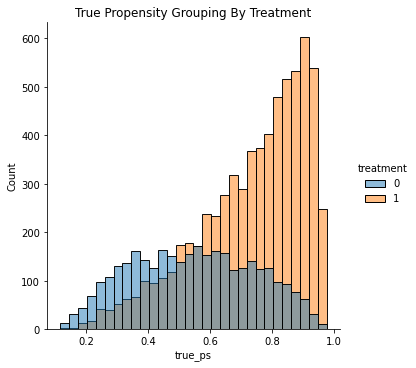

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(df, x='true_ps', hue='treatment')
plt.title("True Propensity Grouping By Treatment")

## Why do we Need Matching?

It is no secret that you need to consider confounding factors when you try to make any claim that people might have a causal read.[1] 
Suppose a data scientist has correctly identified `a` to `f` as confounding factors and decides to include them in their analysis. Following the common practice, they run a regression on the treatment label and all the confounding features, as follows.

In [ ]:
import statsmodels.formula.api as smf

print(smf.ols('outcome ~ treatment + a + b + c + d + e + f', data=df).fit().summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     2333.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        11:32:26   Log-Likelihood:                -17104.
No. Observations:               10000   AIC:                         3.422e+04
Df Residuals:                    9992   BIC:                         3.428e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3330      0.060     -5.536      0.0

They find the model attributes a `-0.1` effect to the treatment, and it is statistically significant under conventional thresholds. If the data scientist is not careful, they would conclude the treatment negatively impacts the outcome.
 
Because we know the underlying data generating process, we know this `-0.1` effect is false. But why does the model attribute any effect to the treatment? In this model the confounders enter the regression in a linear way. Because the functional form is not able to fully capture the true relationship (the nonlinearity we cooked up in the data generating part) and the treatment label is correlated with those confounding features, some of the nonlinear effects are attributed to the treatment.
 
Can a nonlinear model help? In theory, yes. If the model is correctly specified (i.e., has the correct functional form), then the model is able to find the true treatment effect is zero. But without knowing the true relationship, this is unlikely to happen. Can you guess the true functional form that I arbitrarily wrote down just by looking at the date? Probably not.
 
Only if there is a method to incorporate confounders without knowing how they affect the outcome... Lucky you, we do have such a method. This method is, guess what, propensity score matching (or matching in general).[2]
 
Before I explain how, let's first go through the whole matching process. A typical PSM workflow has three steps:
1. Build a model for the propensity score.
1. Find matched pairs based on the predicted propensity.
1. Perform analysis using the matched sample.
 
### Build a Propensity Score Model
 
Because we only consider the binary treatment here, a propensity score model is just a binary classifier that can make probability predictions.
 
Here I will cheat a little bit. I run a simple (means not regularized) logistic regression as the propensity model. Because we already know the data generating process of the propensity score, this is the most efficient model.
 
In a real problem, you may want to use a more capable classifier. If you decide to train a binary classifier like your typical ML project, then you still want to follow the best practices on the bias and variance tradeoff. In this use case, however, we do not care about accuracy/precision/recall/f1 or any other evaluation metrics that only compare binary predictions against their labels. Instead, you want to choose an evaluation metric that captures the goodness of predicted probabilities. The good old "log loss" is usually a good choice.


In [ ]:
ps_model = smf.logit('treatment ~ a + b + c + d + e + f', data=df).fit()
print(ps_model.summary())

Optimization terminated successfully.
         Current function value: 0.535076
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9993
Method:                           MLE   Df Model:                            6
Date:                Sun, 30 May 2021   Pseudo R-squ.:                  0.1592
Time:                        11:32:27   Log-Likelihood:                -5350.8
converged:                       True   LL-Null:                       -6363.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0139      0.100     -0.139      0.890      -0.211       0.183
a              1.0020      0.

The predicted propensity score is simply the probability prediction on the training set. Do not worry about the traditional ML's insistence on the out-of-sample predictions in this case.

In [ ]:
# make the propensity score prediction
df['_score'] = ps_model.predict()

### Pairing up using the Propensity Predictions

I use the following algorithm to form matched paris.[3] In the literature, this method is called the nearest neighbor with a caliper. It is a greedy algorithm. It iteratively forms pairs using the closest matches that are within a certain threshold (caliper) without replacement. You can also go for the optimal matching that minimizes the average distance within pairs, although studies (e.g., Gu and Rosenbaum, 1993) show their empirical performances are typically on par with each other. 

In [ ]:
def match(
    data: pd.DataFrame, 
    threshold: float = 0.0001, 
    treatment_col: str = "treatment", 
    score_col: str = "_score",
    match_id_col: str = "_match_id",
) -> pd.DataFrame:
    """
    Finds a suitable pair for each record in the dataset, if one exists.
    Records are excluded from the final matched dataset if there are no suitable matches.
    """
    assert score_col in data.columns, "Propensity Scores have not been calculated"

    pairs = {}
    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]
    # Because nearest neighbor matching is greedy,
    # a random shuffle here removes any structures in the data.
    # I fixed the random_state for reproductivity, in practice
    # you want to remove the fixed random_state
    for index, score in treated[score_col].sample(frac=1, random_state=0).iteritems():
        diff = (control[score_col] - score).abs().sort_values()
        for candidate_index, delta in diff.iteritems():
            # because diff is sorted, we can assure
            # there's no valid pair if delta is larger than the threshold
            if delta > threshold:
                break
            # candidate has already formed a pair
            if candidate_index in pairs:
                continue
            else: 
                # candidate is available to form a match
                pairs[candidate_index] = index
                break

    # remove/initialize the match_id column
    data[match_id_col] = np.nan
    match_id = 0
    for control_index, treated_index in pairs.items():
        data.at[control_index, match_id_col] = match_id
        data.at[treated_index, match_id_col] = match_id
        match_id += 1
    return data[data[match_id_col].notnull()]

Let's take a peek at the post match data. The `_score` column is the predicted propensity score. As expected, it is close to the true score. The column `_match_id` is the id of the pair. Two rows that form a comparable pair in this dataframe share one id.

Notice that the size of the matched sample is much smaller because we dropped all the single data points.

In [ ]:
matched_df = match(df)
print(f"Size of the matched sample: {len(matched_df)}")
matched_df.head()

Size of the matched sample: 3650


,a,b,c,d,e,f,true_ps,treatment,outcome,_score,_match_id
0,0.548814,0.715189,0.602763,0.544883,0.423655,0.645894,0.782797,0,1.740649,0.781791,1508.0
1,0.437587,0.891773,0.963663,0.383442,0.791725,0.528895,0.865575,0,0.953746,0.867669,855.0
3,0.778157,0.870012,0.978618,0.799159,0.461479,0.780529,0.836363,1,3.800730,0.835596,453.0
5,0.264556,0.774234,0.456150,0.568434,0.018790,0.617635,0.779156,0,2.227795,0.778735,251.0
6,0.612096,0.616934,0.943748,0.681820,0.359508,0.437032,0.802197,1,-0.514348,0.801336,1211.0


### Analysis with the Matched Sample

On this matched sample, let's run the original regression again and see if the result is any different.

In [ ]:
print(smf.ols('outcome ~ treatment + a + b + c + d + e + f', data=matched_df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     669.7
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        11:32:37   Log-Likelihood:                -5963.9
No. Observations:                3650   AIC:                         1.194e+04
Df Residuals:                    3642   BIC:                         1.199e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2469      0.088     -2.790      0.0

Look at the coefficient on the treatment. This time we correctly fail to reject the treatment effect being zero. This shows the effectiveness of propensity score matching.

But what's going on? The reason is that PSM removes the mix shift and balances the data in all dimensions. When the data itself is balanced, the functional form does not matter any more.

For a concrete example, let's examine the distribution of feature `a` before and after the matching. Here is its distribution before the matching, grouping by the treatment.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


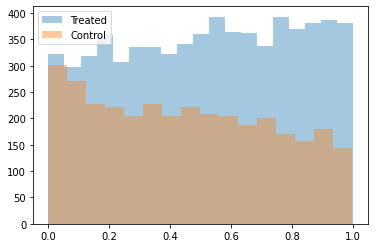

In [ ]:
sns.distplot(x=df[df['treatment'] == 1]['a'], label='Treated', kde=False)
sns.distplot(x=df[df['treatment'] == 0]['a'], label='Control', kde=False)
plt.legend()

Now you see it. The feature is not balanced with respect to the treatment before the matching. Recall the doctor example in the introduction, we hope to find two groups that are comparable and now the two groups are not. Because feature `a` plays a key and non-linear role in producing the outcome, this mix shift effect is wrongly associated with the treatment label. 

To show this visually, let's check the scatter plot between `a` and the outcome.

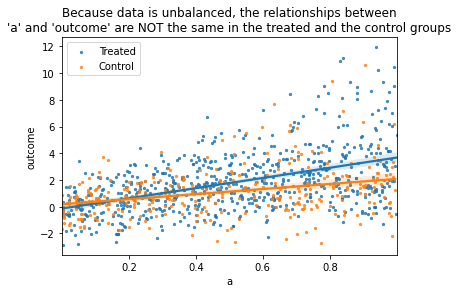

In [ ]:
downsampled_data = df.sample(frac=0.1, random_state=0)
sns.regplot(data=downsampled_data[downsampled_data['treatment'] == 1], x='a', y='outcome', label="Treated", scatter_kws={'s': 5})
sns.regplot(data=downsampled_data[downsampled_data['treatment'] == 0], x='a', y='outcome', label="Control", scatter_kws={'s': 5})
plt.title("Because data is unbalanced, the relationships between\n'a' and 'outcome' are NOT the same in the treated and the control groups")
plt.legend()

We can see more blue points on the right up corner, which moves up the blue line. Roughly speaking, the gap between the two lines (caused by mix shift) is wrongly attributed to the treatment label.

Let's visit the matched sample and see if we can find any mix shift.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


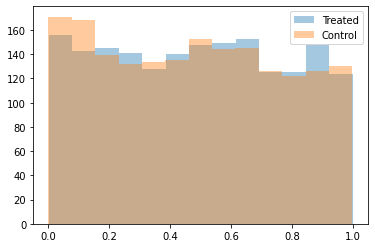

In [ ]:
sns.distplot(x=matched_df[matched_df['treatment'] == 1]['a'], label='Treated', kde=False)
sns.distplot(x=matched_df[matched_df['treatment'] == 0]['a'], label='Control', kde=False)
plt.legend()

Text(0.5, 1.0, "Because data is balanced, the relationships between\n'a' and 'outcome' are the same in the treated and the control groups")

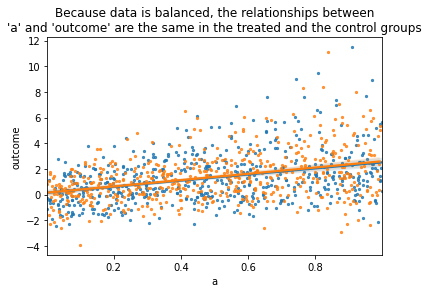

In [ ]:
downsampled_matched_data = matched_df.sample(frac=0.3, random_state=0)
sns.regplot(data=downsampled_matched_data[downsampled_matched_data['treatment'] == 0], x='a', y='outcome', label="Control", scatter_kws={'s': 5})
sns.regplot(data=downsampled_matched_data[downsampled_matched_data['treatment'] == 1], x='a', y='outcome', label="Treated", scatter_kws={'s': 5})
plt.title("Because data is balanced, the relationships between\n'a' and 'outcome' are the same in the treated and the control groups")

The answer is no.

## The Ignorability Assumption

The ignorability (also known as unconfoundedness, conditional independence, or selection on observables) assumption means we have included all the features that affect both the outcome and the treatment assignment in our models. This is a tricky assumption: it is super duper important and yet very hard to test. You can check [this](https://arxiv.org/pdf/2012.15716.pdf) 80-page and full-of-math paper if you feel like learning something. I'll give you a simple procedure to test this assumption only using `scikit-learn`. But before we do this, let me first emphasize its importance.

### The Violation of the Ignorability Assumption

Not all problems in data science are sensitive to assumptions. Therefore, maybe not all of your fellow data scientists are allergic to skipping tests on assumptions. How bad can it be if we fail to include some features? We lose 1% of model performance? Who cares?

Well the answer is the estimated treatment effect can be biased. This bias can lead to qualitatively incorrect business decisions that might cost you millions or more.

In the following simulation, let's exclude `a` and `b`. In practice, maybe you are not aware of their importance; maybe it takes weeks to build the pipeline to process them; maybe you never gather them to begin with; or maybe they are private to your users and you can never observe it (e.g., the true feeling about your product). In this exercise, we know both of them are critical for the propensity and the outcome equations. Therefore, we're violating the ignorability assumption. Is this a big deal? Let's find out.

We run the propensity score model, generate the propensity score prediction, and do the matching as usual.

In [ ]:
# The suffix `ov` means omitted variable bias.
# The name comes from that we have omitted important variables.
ps_model_ov = smf.logit('treatment ~ c + d + e + f', data=df).fit()
print(ps_model_ov.summary())
df['_score_ov'] = ps_model_ov.predict()

Optimization terminated successfully.
         Current function value: 0.609952
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9995
Method:                           MLE   Df Model:                            4
Date:                Sun, 30 May 2021   Pseudo R-squ.:                 0.04149
Time:                        11:32:52   Log-Likelihood:                -6099.5
converged:                       True   LL-Null:                       -6363.5
Covariance Type:            nonrobust   LLR p-value:                5.868e-113
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6560      0.081     20.360      0.000       1.497       1.815
c             -0.1459      0.

In [ ]:
matched_df_ov = match(df, score_col="_score_ov", match_id_col="_math_id_ov")
print(f"Size of the matched sample: {len(matched_df_ov)}")
matched_df_ov.head()

Size of the matched sample: 5396


,a,b,c,d,e,f,true_ps,treatment,outcome,_score,_match_id,_score_ov,_math_id_ov
1,0.437587,0.891773,0.963663,0.383442,0.791725,0.528895,0.865575,0,0.953746,0.867669,855.0,0.653544,1798.0
5,0.264556,0.774234,0.456150,0.568434,0.018790,0.617635,0.779156,0,2.227795,0.778735,251.0,0.624952,1186.0
7,0.697631,0.060225,0.666767,0.670638,0.210383,0.128926,0.619423,0,-0.018675,0.611799,NaN,0.791112,11.0
8,0.315428,0.363711,0.570197,0.438602,0.988374,0.102045,0.748086,0,0.662756,0.746257,NaN,0.808199,39.0
11,0.820993,0.097101,0.837945,0.096098,0.976459,0.468651,0.501851,1,-0.164941,0.496887,268.0,0.684249,422.0


Then, same as before, we run the outcome regression with the matched data.

In [ ]:
print(smf.ols('outcome ~ treatment + c + d + e + f', data=matched_df_ov).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     316.0
Date:                Sun, 30 May 2021   Prob (F-statistic):          1.43e-297
Time:                        11:33:37   Log-Likelihood:                -10892.
No. Observations:                5396   AIC:                         2.180e+04
Df Residuals:                    5390   BIC:                         2.184e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1120      0.098     21.636      0.0

The model attributes `1.1` to the treatment (and this number is statistically significant in all conventional significance levels). If we were to make business decisions based on this analysis, we would reach a false conclusion and potentially lose a lot.

Why do we end up with `1.1` on the treatment's coefficient? Because `a` and `b` are important to the outcome and yet we do not include them, the regression tries to attribute some of their effects on the treatment label, which is correlated with `a` and `b`.

In summary, we violate the ignorability assumption and the estimated treatment effect can be much biased. 

## How to test ignorability?
Now we know we should really treat the ignorability assumption seriously. But how do we know if we meet this assumption or not?
At first sight, the ignorability assumption is difficult to test. How do you test whether you have missed features that you might have never considered their existence?
 
Sometimes you don't have to. When you control the treatment assignment process, you already know which features influence the propensity. For example, a doctor may decide her prescription based on a set of lab results; your marketing team may decide which users to send a coupon code based on a spreadsheet. In either case, we only need to grab the information the doctor or your marketing team has.
 
But what if you don't fully understand the treatment assignment process? In this situation, you might have a laundry list of features but you are still worried about the ignorability assumption: your laundry list might just miss a couple key items.
 
To test whether your laundry list is good enough, we need to utilize the residuals. For any model, residuals contain information in the training labels that cannot be attributed to the included features. In other words, residuals summarize the unincluded features that would be relevant to the model if they were included.
 
To perform tests on the ignorability assumption, we need to model the outcome as well. If the ignorability assumption holds, then we should expect the residuals of the propensity model and the outcome model to be independent because we have already included features that are critical to both. Conversely, we know we have missed something important.[4]
 
Let's put this idea to the test.

 
### The Outcome Model
 
Because the data generating process for the outcome is nonlinear, we need a model that can fit a flexible functional form. Here I choose LightGBM simply because I'm currently playing with LightGBM. You should feel free to choose others as long as they can capture complex nonlinear relationships (e.g., XGBoost or some AutoML framework).


In [ ]:
from typing import Dict, Union
import lightgbm as lgb

def train_lightgbm_model(
    params: Dict[str, Union[str, float]], 
    lgb_dataset: lgb.Dataset, 
    num_boost_round: int = 0
) -> lgb.Booster:
    """
    Train a lightgbm model.

    When num_boost_round <= 0, use cv to find the optimal num_boost_round.
    """
    # lightgbm sets stratified = True by default 
    # but we need to set it to False for regression
    stratified = True if params.get("objective") == "binary" else False

    if num_boost_round <= 0:
        cv_result = lgb.cv(
            params=params,
            train_set=lgb_dataset,
            early_stopping_rounds=50,
            return_cvbooster=True,
            stratified=stratified,
        )
        num_boost_round = cv_result["cvbooster"].best_iteration

    return lgb.train(
        params=params,
        train_set=lgb_dataset,
        num_boost_round=num_boost_round,
    )

In [ ]:
outcome_model = train_lightgbm_model(
    params={"objective": "regression", "metric": "rmse"},
    lgb_dataset=lgb.Dataset(
        data=df[list('abcdef') + ['treatment']],
        label=df['outcome'],
    )
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_

Now we have the outcome model. Let's compute residuals from the two models.

In [ ]:
df["_outcome_prediction"] = outcome_model.predict(df[list('abcdef') + ['treatment']])
df["outcome_residuals"] = df["outcome"] - df["_outcome_prediction"]
df["propensity_residuals"] = df["treatment"] - df["_score"]

Here is a scatter plot of the two sets of residuals.

Text(0.5, 1.0, 'Outcome and Propensity Residuals (Correct Model)')

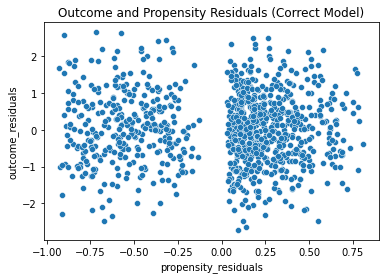

In [ ]:
sns.scatterplot(data=df.sample(frac=0.1), x="propensity_residuals", y="outcome_residuals")
plt.title("Outcome and Propensity Residuals (Correct Model)")

From the picture it is hard to tell if there is any relationship. Can we have a formal hypothesis test?
 
### Test Residual Dependence with Mutual Information
 
It turns out we have an established measure on the dependence between two random variables in information theory. This measure is called [mutual information](https://en.wikipedia.org/wiki/Mutual_information) (MI). If two random variables are independent, then their MI is equal to 0. Otherwise it will be above 0.
 
Its sample counterpart is a statistic that measures the dependence of two random samples. `scikit-learn` has an [implementation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) under its `feature_selection` module (yes its intended usage is to do feature selection, feel free to explore this usage).

I use the following code snippet to compute MI. It is a light wrapper of `mutual_info_regression` that ensures the input has the desired shape and the output is a scalar.

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def compute_mutual_info(
    propensity_residuals: pd.Series, outcome_residuals: pd.Series
) -> float:
    mutual_info = mutual_info_regression(
        X=propensity_residuals.values.reshape(-1, 1),
        y=outcome_residuals,
    )
    return mutual_info.item()

Unfortunately, the distribution of the sample MI is unclear (Hutter 2002 has a Bayesian posterior derivation, but its frequentist derivation to my knowledge does not exist yet). But, under the null hypothesis, it is very easy to bootstrap its distribution and compute the p value.

The idea of the bootstrap is quite simple. Under the null hypothesis, the two residuals are independent. So, any re-sample should not change the statistical behavior of the two residual samples. Re-sample, on the other hand, guarantees independence. So conversely if the two sets of residuals are not independent, then the original MI will be quite different from the re-sampled MI.
 
The code snippet for bootstrapping MI is given as follows.


In [ ]:
from typing import Tuple

def bootstrap_mi(
    propensity_residuals: pd.Series, 
    outcome_residuals: pd.Series, 
    mutual_info: float,
) -> Tuple[float, np.array]:
    bootstrapped_mi = []
    for _ in range(1000):
        bootstrapped_mi.append(
            compute_mutual_info(
                propensity_residuals.sample(frac=1, replace=True),
                outcome_residuals.sample(frac=1, replace=True),
            )
        )
    bootstrapped_mi = np.array(bootstrapped_mi)
    p_value = np.sum(bootstrapped_mi > mutual_info) / len(bootstrapped_mi)
    return p_value, bootstrapped_mi

Let's try it on the models that satisfy the ignorability assumption.

In [ ]:
mutual_info = compute_mutual_info(df["propensity_residuals"], df["outcome_residuals"])
p_value, _ = bootstrap_mi(df["propensity_residuals"], df["outcome_residuals"], mutual_info)
print((mutual_info, p_value))

(0, 0.52)


As expected, the sample MI of the two residuals is close to zero and the p value is also safely above 0. 

What if we exclude important variables? Let's try the residuals that come from the wrong models.

In [ ]:
outcome_model_ov = train_lightgbm_model(
    params={"objective": "regression", "metric": "rmse"},
    lgb_dataset=lgb.Dataset(
        data=df[list('cdef') + ['treatment']],
        label=df['outcome'],
    )
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_

In [ ]:
df["_outcome_prediction_ov"] = outcome_model_ov.predict(df[list('cdef') + ['treatment']])
df["outcome_residuals_ov"] = df["outcome"] - df["_outcome_prediction_ov"]
df["propensity_residuals_ov"] = df["treatment"] - df["_score_ov"]

Text(0.5, 1.0, "Outcome and Propensity Residuals (Exclud 'a' and 'b')")

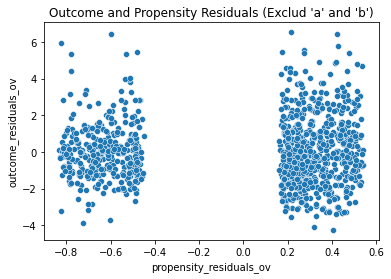

In [ ]:
sns.scatterplot(data=df.sample(frac=0.1), x="propensity_residuals_ov", y="outcome_residuals_ov")
plt.title("Outcome and Propensity Residuals (Exclud 'a' and 'b')")

It is still hard to decipher the scatterplot. Let's compute the MI and do the bootstrap.

In [ ]:
mutual_info_ov = compute_mutual_info(df["propensity_residuals_ov"], df["outcome_residuals_ov"])
p_value_ov, _ = bootstrap_mi(df["propensity_residuals_ov"], df["outcome_residuals_ov"], mutual_info_ov)
print((mutual_info_ov, p_value_ov))

(0.019752510285854896, 0.006)


Compared to the previous case, here the MI is much higher and the p value is close 0. We can safely reject the null that we have included all the relevant features.

## Summary

PSM is a valuable tool to help you establish the causal relationship from observational data. It can take care of confounders even if you do not know how the confounders influence the outcome. However, for the PSM to be successful, you need to make sure the ignorability assumption holds. 


## Notes

[1] For example, you may be careful enough to write down sentences like "X is *associated* with a better outcome", but you just fool yourself if your stakeholders use it to make decisions as if X *causes* a better outcome.

[2] Informed readers may have read King and Nielsen's (2019) criticism on the PSM. I find their advice hardly applicable on real world datasets where you may have hundreds or thousands of features of mixed types. Because of the curse of dimensionality, you can rarely find counterparts of a data point in its vicinity. So you end up with dropping a big chunk of your dataset if you want to mimic a fully blocked experiment.

[3] Well I don't actually use it, but it helps you to understand what the matching actually does. You probably want to use an existing package like [MatchIt](https://cran.r-project.org/web/packages/MatchIt/index.html) in your own work. If you need to implement a nearest neighbor matching yourself, you should go for an efficient nearest neighbor algorithm.

[4] For the informed readers, the idea is inspired by the Heckman selection model. 


## References

Gu, Xing Sam, and Paul R. Rosenbaum. "Comparison of multivariate matching methods: Structures, distances, and algorithms." Journal of Computational and Graphical Statistics 2.4 (1993): 405-420.

Hutter, Marcus. "Distribution of mutual information." Advances in neural information processing systems 1 (2002): 399-406.

King, Gary and Richard Nielsen. "Why Propensity Scores Should Not Be Used for Matching." Political Analysis 27, 4 (May 2019): 435-454.

Masten, Matthew A., Alexandre Poirier, and Linqi Zhang. "Assessing Sensitivity to Unconfoundedness: Estimation and Inference." arXiv preprint arXiv:2012.15716 (2020).